Tutorials of CPS using DLPFC dataset
===
**Interpretations of attention scores**
1. read the dataset
2. construct the graph (construct the multi-scale features, option)
2. train the model
3. generate the arbitrary resolution spots
4. visualize the results

In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import CPS

In [3]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2025'])
args.prep_scale = False
args.sh_weights = True
args.lr=1e-3
args.max_epoch=1000
args.hvgs=3000
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/1-DLPFC/'
CPS.set_random_seed(args.seed)
args

Namespace(batch_size=256, clusters=7, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/1-DLPFC/', decoder='MLP', decoder_latent=[256, 512], distill=1.0, dropout=0.2, flow='source_to_target', freq=32, gpu=0, hvgs=3000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 4, 5, 6, 7], latent_dim=64, lr=0.001, max_epoch=1000, max_neighbors=6, n_spot=0, num_heads=4, prep_scale=False, radius=150, seed=2025, self_loops=True, sh_weights=True, sigma=1.0, visual=True, weight_decay=0.0001)

Read the adata

In [4]:
section = '151673'
adata = sc.read_visium(os.path.join(args.dataset_path+section))
Ann_df = pd.read_csv(os.path.join(args.dataset_path+'1-DLPFC_annotations/', section+'_truth.txt'), 
                     sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Preprocess adata

In [5]:
adata.var_names_make_unique()

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
sc.pp.normalize_total(adata, target_sum=1e4)
adata.layers["counts"] = adata.X.copy()
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=True, max_value=10)

adata_hvg = adata[:, adata.var['highly_variable']].copy()
counts_layer = adata_hvg.layers['counts']

adata.obsm['hvg_features'] = adata_hvg.X
adata.obsm['hvg_counts'] = counts_layer.toarray()

In [6]:
# adata.var_names_make_unique()
# sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
# sc.pp.normalize_total(adata, target_sum=1e4)
# # sc.pp.log1p(adata)
# # sc.pp.scale(adata, zero_center=True, max_value=10)

# adata_hvg = adata[:, adata.var['highly_variable']].copy()
# adata.obsm['hvg_features'] = adata_hvg.X.toarray()

Construct the spatial graph

In [7]:
spatial_edge = CPS.SpatialGraphBuilder(args)
pyg_data = spatial_edge.build_single_graph(adata, method='rknn')
print(pyg_data.num_nodes, pyg_data.num_genes)

3639 3000


Train the CPS model

In [8]:
cps_model = CPS.CPSTrainer(args)
cps_model.fit(pyg_data)

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch   0: Train[Total:6.7015, T:2.9667, S:2.9667, D:0.7681]

Epoch  10: Train[Total:4.2383, T:1.8514, S:1.8538, D:0.5331]

Epoch  20: Train[Total:3.0314, T:1.3058, S:1.3257, D:0.3999]

Epoch  30: Train[Total:2.5138, T:1.0511, S:1.0770, D:0.3858]

Epoch  40: Train[Total:2.3011, T:0.9417, S:0.9751, D:0.3844]

Epoch  50: Train[Total:2.2303, T:0.9117, S:0.9509, D:0.3677]

Epoch  60: Train[Total:2.2239, T:0.8964, S:0.9394, D:0.3882]

Epoch  70: Train[Total:2.2173, T:0.8852, S:0.9311, D:0.4009]

Epoch  80: Train[Total:2.2247, T:0.8772, S:0.9250, D:0.4225]

Epoch  90: Train[Total:2.2346, T:0.8701, S:0.9209, D:0.4437]

Epoch 100: Train[Total:2.2433, T:0.8645, S:0.9149, D:0.4639]

Epoch 110: Train[Total:2.2555, T:0.8575, S:0.9116, D:0.4864]

Epoch 120: Train[Total:2.2684, T:0.8536, S:0.9086, D:0.5062]

Epoch 130: Train[Total:2.2446, T:0.8481, S:0.9051, D:0.4914]

Epoch 140: Train[Total:2.2491, T:0.8435, S:0.9037, D:0.5019]

Epoch 150: Train[Total:2.2560, T:0.8396, S:0.9018, D:0.5146]

Epoch 1

Downstream analysis

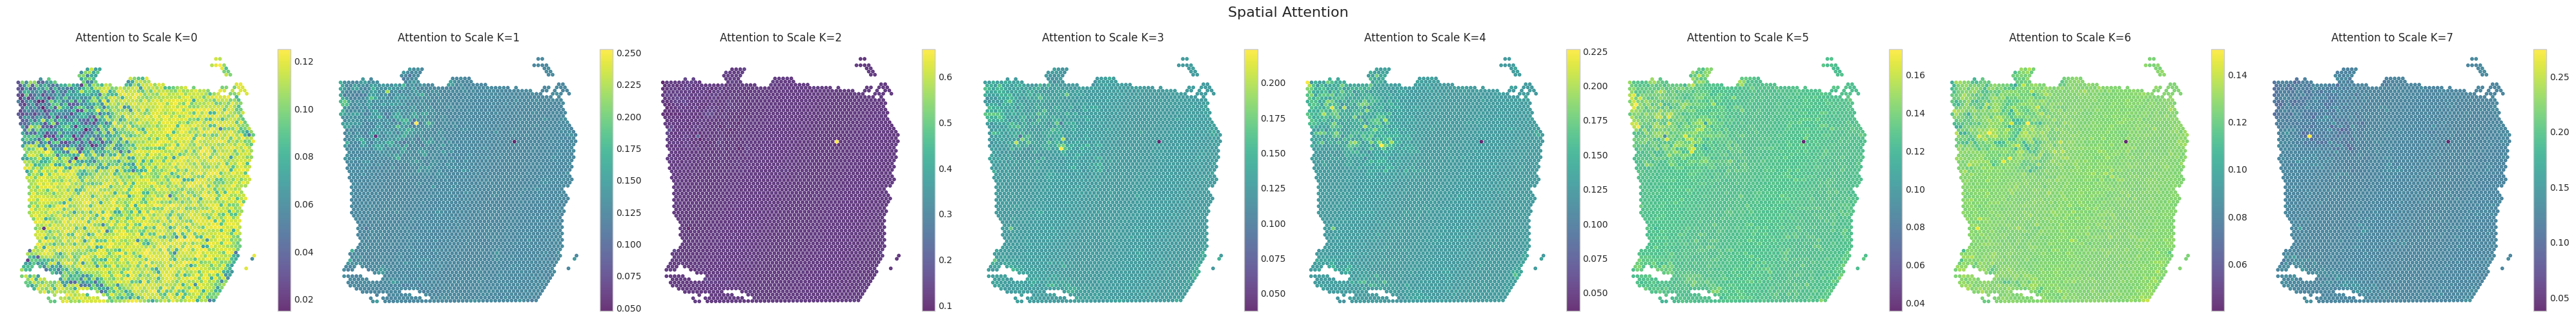

In [9]:
z_s, z_t, attn, fig = cps_model.interpret_attn_scores(pyg_data, return_fig=True)
adata.obsm['z_s'] = z_s
adata.obsm['z_t'] = z_t
adata.obsm['attns'] = attn.reshape(adata.n_obs, 32)
attn = np.mean(attn, axis=2)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


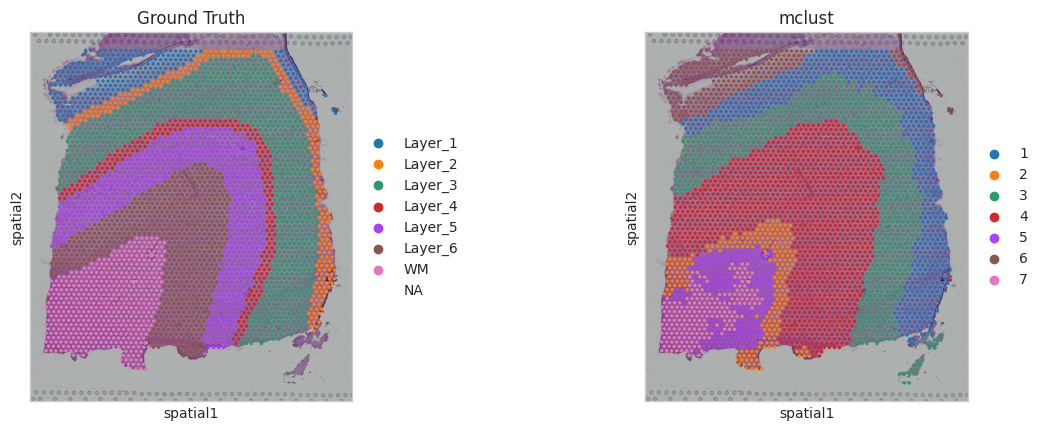

Adjusted rand index = 0.4797


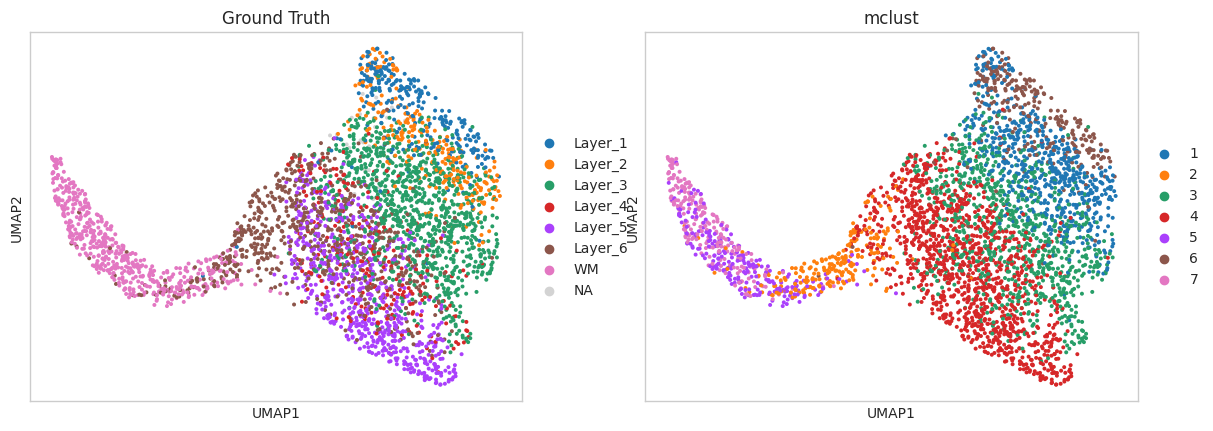

In [10]:
# adata.obsm['z_t'] = latent
adata = CPS.mclust(adata, args, key='z_t', pca_dim=32, refine=True)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth", "mclust"])
sc.pp.neighbors(adata, n_neighbors=15, use_rep='z_t')
sc.tl.umap(adata)
sc.pl.embedding(adata, basis='umap', color=["Ground Truth", "mclust"], show=False)
adata_df = adata[~pd.isnull(adata.obs['Ground Truth'])]
obs_df = adata_df.obs.dropna()
from sklearn.metrics.cluster import adjusted_rand_score
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.4f' %ARI)

fitting ...
  |======================================================================| 100%


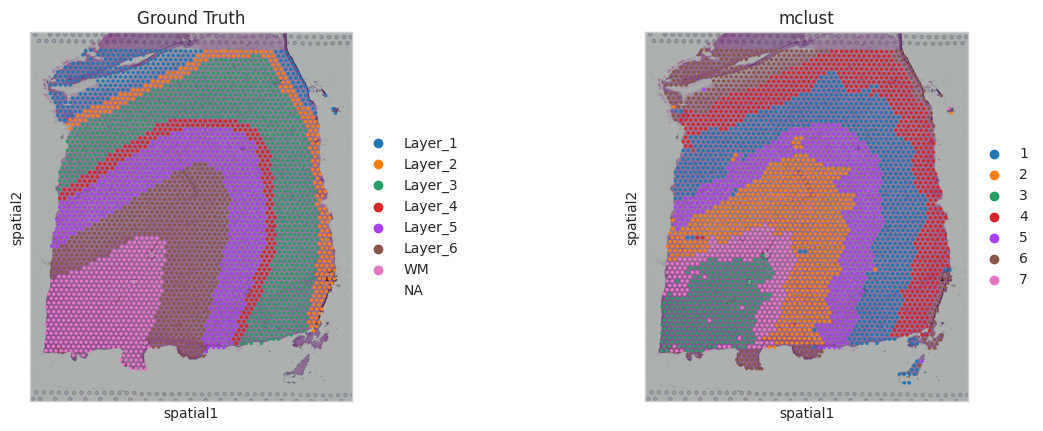

Adjusted rand index = 0.5375


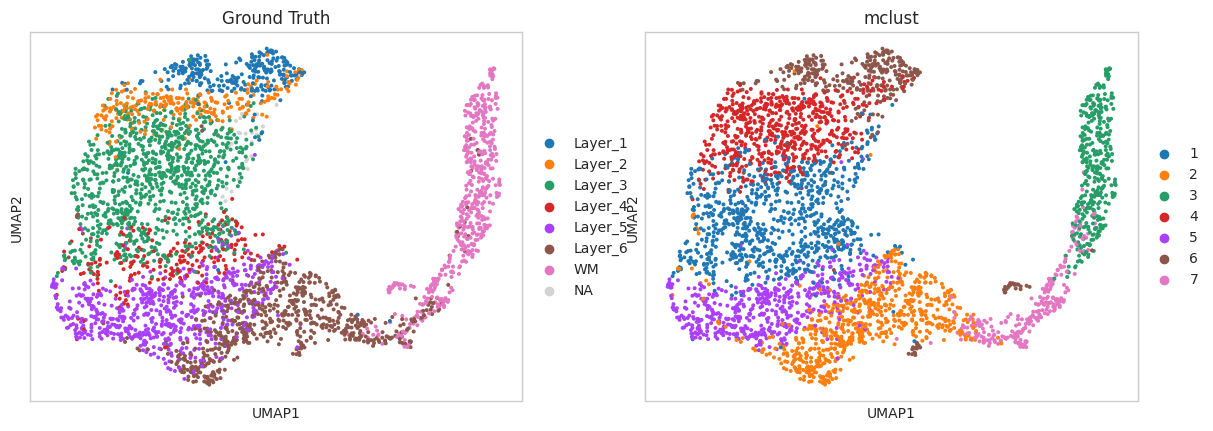

In [11]:
# adata.obsm['z_t'] = latent
adata = CPS.mclust(adata, args, key='z_s', pca_dim=32, refine=False)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth", "mclust"])
sc.pp.neighbors(adata, n_neighbors=15, use_rep='z_s')
sc.tl.umap(adata)
sc.pl.embedding(adata, basis='umap', color=["Ground Truth", "mclust"], show=False)
adata_df = adata[~pd.isnull(adata.obs['Ground Truth'])]
obs_df = adata_df.obs.dropna()
from sklearn.metrics.cluster import adjusted_rand_score
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.4f' %ARI)

fitting ...
  |======================================================================| 100%


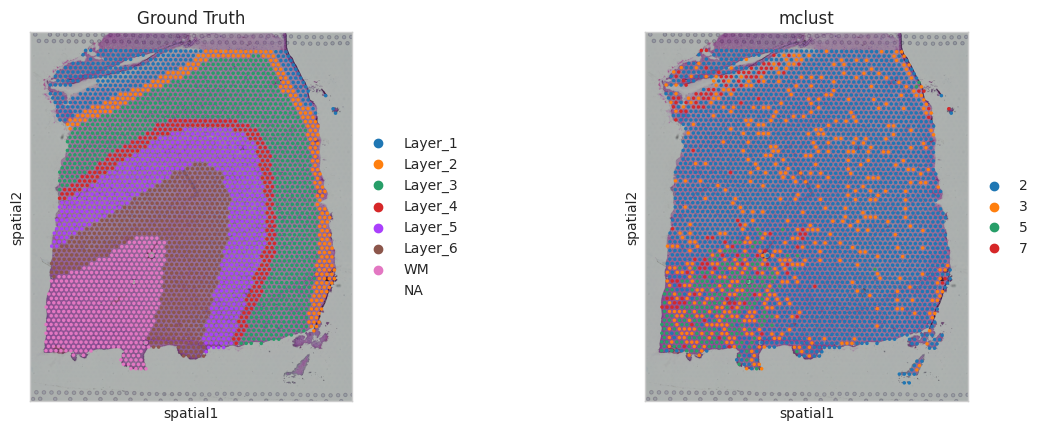

Adjusted rand index = 0.0782


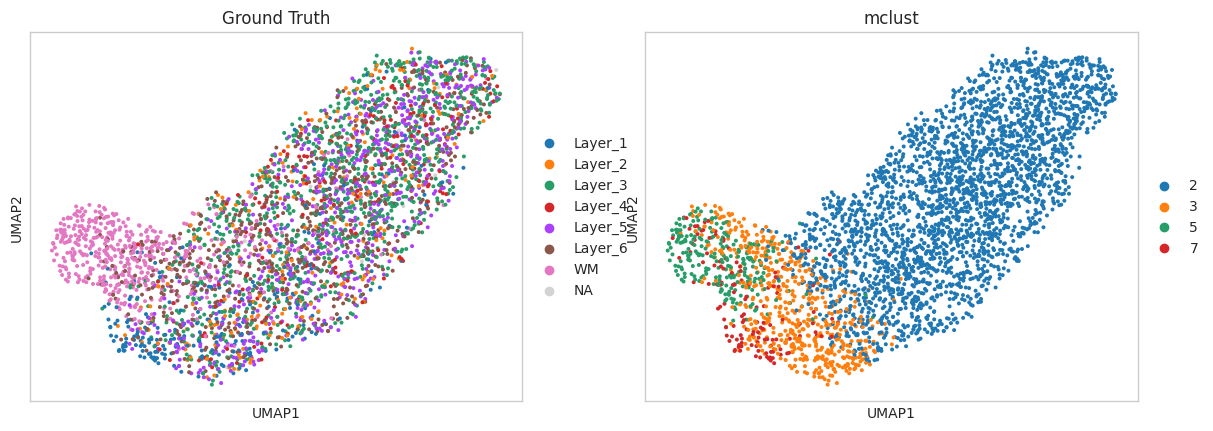

In [12]:
adata = CPS.mclust(adata, args, key='attns', pca_dim=16, refine=False)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth", "mclust"])
sc.pp.neighbors(adata, n_neighbors=15, use_rep='attns')
sc.tl.umap(adata)
sc.pl.embedding(adata, basis='umap', color=["Ground Truth", "mclust"], show=False)
adata_df = adata[~pd.isnull(adata.obs['Ground Truth'])]
obs_df = adata_df.obs.dropna()
from sklearn.metrics.cluster import adjusted_rand_score
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.4f' %ARI)

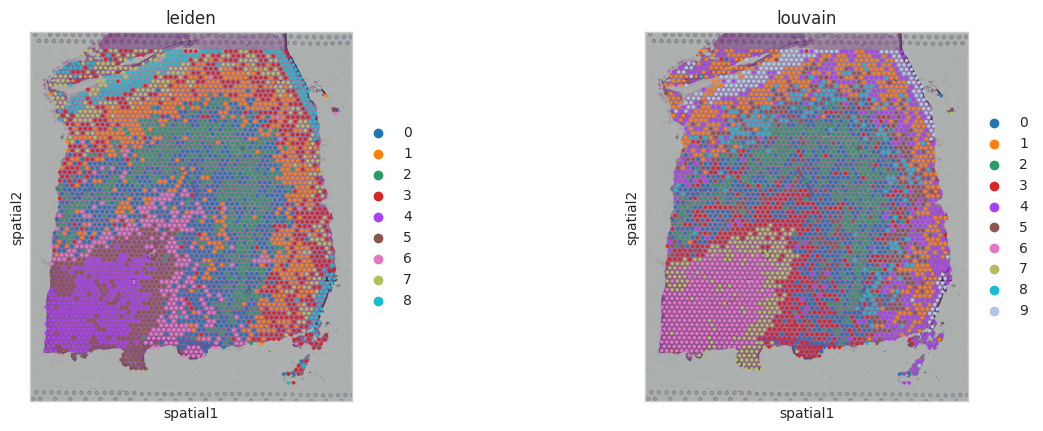

Adjusted rand index = 0.2868
Adjusted rand index = 0.2578


In [13]:
import scanpy as sc
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.sparse import csr_matrix

# 1. 获取隐空间表征
z = adata.obsm['z_s']  # 形状: (n_cells, latent_dim)

# 2. 使用KNN构建邻接图
n_neighbors = 20
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
nbrs.fit(z)
distances, indices = nbrs.kneighbors(z)

# 3. 可以转换为scanpy可用的邻接矩阵
from scipy.sparse import csr_matrix
knn_graph = csr_matrix((np.ones_like(distances.ravel()), 
                       indices.ravel(), 
                       range(0, distances.size+1, n_neighbors)), 
                      shape=(adata.n_obs, adata.n_obs))

# 4. 存储邻接矩阵到adata
adata.obsp['distances'] = knn_graph

# 5. 使用Leiden或Louvain聚类（基于KNN图）
sc.pp.neighbors(adata, use_rep='z_t', knn=20)  # 使用隐空间表征
sc.tl.leiden(adata, resolution=0.5)  # 聚类结果存入 adata.obs['leiden']
# 或
sc.tl.louvain(adata, resolution=1)  # 聚类结果存入 adata.obs['louvain']
sc.pl.spatial(adata, img_key="hires", color=["leiden",'louvain'])
# 查看聚类结果
adata_df = adata[~pd.isnull(adata.obs['Ground Truth'])]
obs_df = adata_df.obs.dropna()
from sklearn.metrics.cluster import adjusted_rand_score
ARI = adjusted_rand_score(obs_df['leiden'], obs_df['Ground Truth'])
print('Adjusted rand index = %.4f' %ARI)
ARI = adjusted_rand_score(obs_df['louvain'], obs_df['Ground Truth'])
print('Adjusted rand index = %.4f' %ARI)

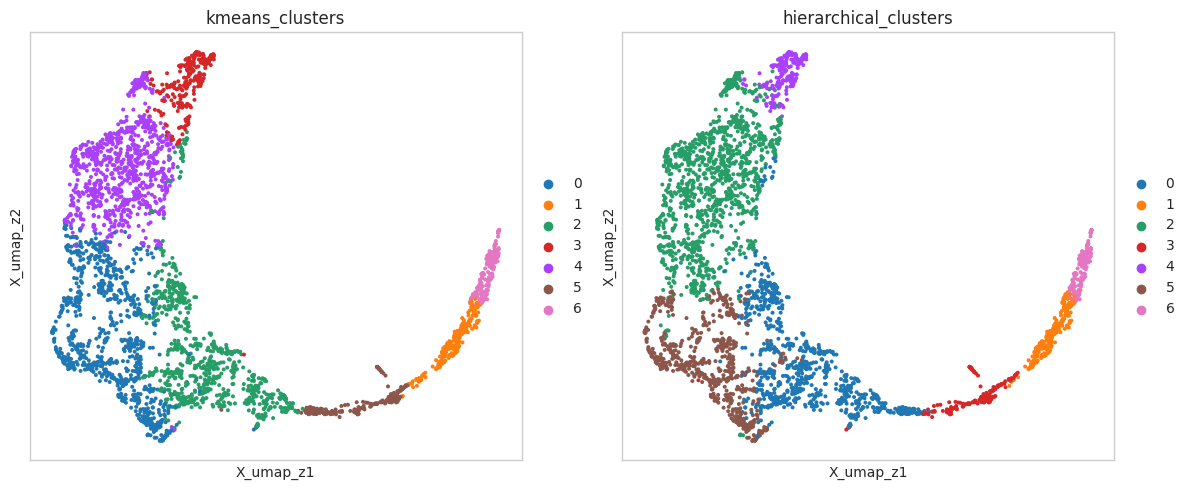

In [14]:
import scanpy as sc
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.sparse import csr_matrix

# 1. 获取隐空间表征
z = adata.obsm['z_s'] 

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import umap
import matplotlib.pyplot as plt

# 1. 使用K-means聚类（需要指定k值）
k = 7
kmeans = KMeans(n_clusters=k, random_state=42)
adata.obs['kmeans_clusters'] = kmeans.fit_predict(z).astype(str)

# 2. 使用层次聚类
agg_cluster = AgglomerativeClustering(n_clusters=k, linkage='ward')
adata.obs['hierarchical_clusters'] = agg_cluster.fit_predict(z).astype(str)

# 3. 可视化聚类结果
# 先降维可视化
reducer = umap.UMAP(random_state=42)
z_umap = reducer.fit_transform(z)
adata.obsm['X_umap_z'] = z_umap

# 绘制聚类结果
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.embedding(adata, basis='X_umap_z', color='kmeans_clusters', ax=axes[0], show=False)
sc.pl.embedding(adata, basis='X_umap_z', color='hierarchical_clusters', ax=axes[1], show=False)
plt.tight_layout()
plt.show()

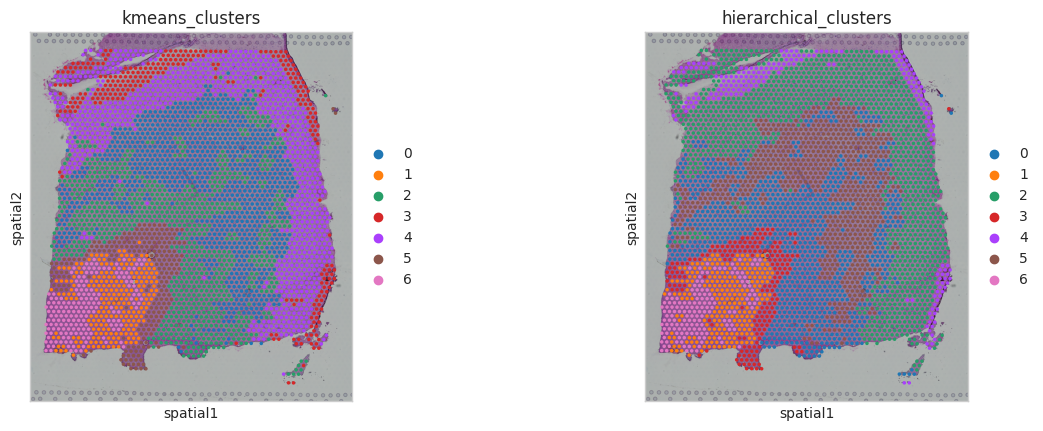

In [15]:
sc.pl.spatial(adata, img_key="hires", color=["kmeans_clusters", 'hierarchical_clusters'])

In [16]:
attn_data = attn
n_scales = attn_data.shape[0]
n_scales

3639

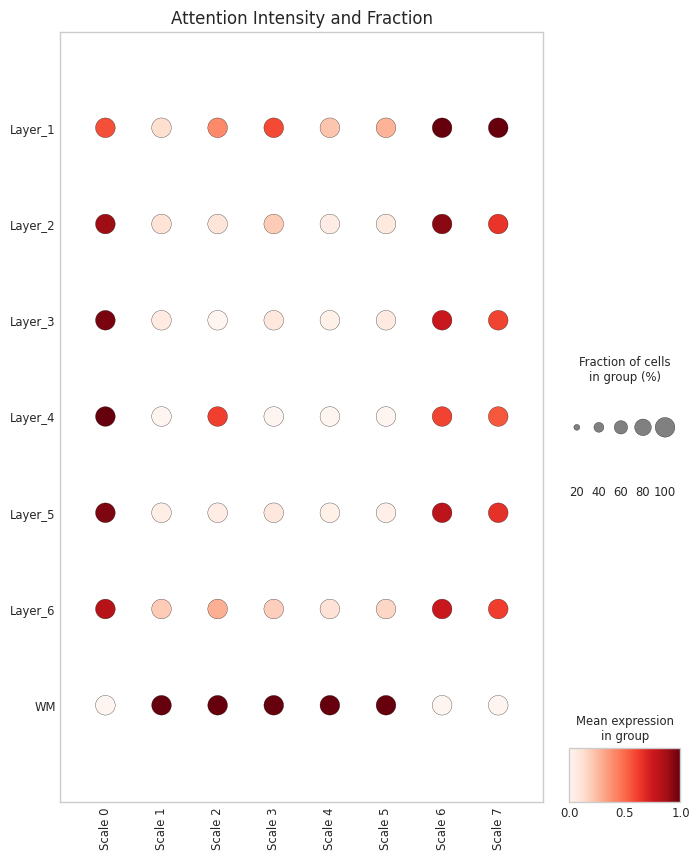

In [17]:
import scanpy as sc
import pandas as pd
import numpy as np

# 1. 提取数据
# 假设 adata.obsm['attn'] 的形状是 (n_cells, n_scales)
attn_data = attn
n_scales = attn_data.shape[1]

# 2. 构建临时的 AnnData 对象
# 我们将 attention score 当作 "基因" 放入 X 中
adata_attn = sc.AnnData(X=attn_data)

# 3. 转移元数据 (Obs)
# 必须把 Ground Truth 标签复制过来，用于分组
adata_attn.obs['Ground Truth'] = adata.obs['Ground Truth'].values

# 4. 命名变量 (Var)
# 给每一个尺度起个名字，这将成为横轴的标签
scale_names = [f'Scale {i}' for i in range(n_scales)]
adata_attn.var_names = scale_names

# 5. 绘制热点图 (Point plot)
# groupby: 纵轴的分组依据 (20个空间域)
# var_names: 横轴的变量 (不同尺度)
sc.pl.dotplot(
    adata_attn, 
    var_names=scale_names, 
    groupby='Ground Truth',
    standard_scale='var',  # 依然建议归一化，以便看清小尺度的变化
    cmap='Reds',
    figsize=(8, 10),
    title='Attention Intensity and Fraction'
)

In [18]:
# attn = np.mean(attn, axis=2)
attn = np.clip(attn, 1e-10, 1.0)
attn = attn / attn.sum(axis=1, keepdims=True)
weights = np.arange(1, 9)  # 尺度权重
SES = attn @ weights
SE = -np.sum(attn * np.log(attn), axis=1)
adata.obs['SES'] = SES
adata.obs['SE'] = SE

[<Axes: title={'center': 'SES'}, xlabel='spatial1', ylabel='spatial2'>]

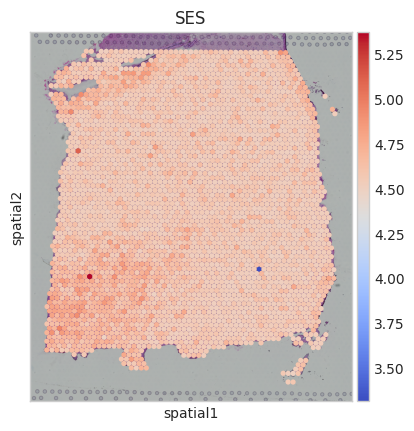

In [19]:
temp_adata = adata.copy()
temp_adata.obs['SES'] = SES
sc.pl.spatial(temp_adata, 
                color='SES',
                show=False, cmap='coolwarm',
                size=1.5)

[<Axes: title={'center': 'SE'}, xlabel='spatial1', ylabel='spatial2'>]

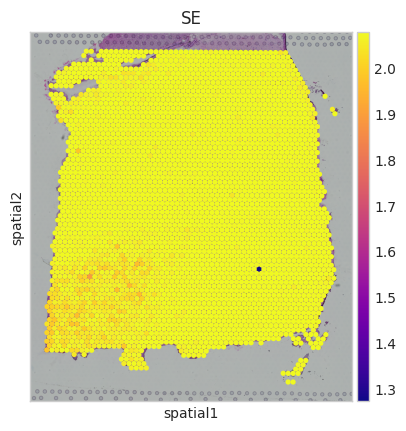

In [20]:
temp_adata = adata.copy()
temp_adata.obs['SE'] = SE
sc.pl.spatial(temp_adata, 
                color='SE',
                show=False, 
                cmap='plasma',
                size=1.5)